# Parte 1 — A Fundamentação Matemática do CRC

## Conceito Básico
O CRC (Cyclic Redundancy Check) trata sequências de bits como polinômios binários para detectar erros de transmissão.

## Definições
- **M(x)**: Mensagem de m bits representada como polinômio
- **G(x)**: Polinômio gerador de grau r (r+1 bits)
- **T(x)**: Quadro transmitido (mensagem + CRC)

## Processo de Geração do CRC

### 1. Anexar r bits '0' ao final da mensagem
- Equivale a multiplicar M(x) por 2^r
- Resulta em M(x) · 2^r

### 2. Dividir M(x) · 2^r por G(x)
- Divisão binária usando operações XOR
- Sem transporte (divisão polinomial)

### 3. O resto da divisão é o CRC
- Fórmula: CRC = (M(x) · 2^r) mod G(x)

### 4. Quadro transmitido T(x)
- T(x) = M(x) · 2^r + CRC
- Estrutura: | mensagem | CRC |
- Tamanho: m + r bits

## Processo de Verificação do CRC

1. **Receptor divide T(x) por G(x)**
2. **Se resto = 0**: Mensagem íntegra ✓
3. **Se resto ≠ 0**: Erro detectado ✗

## Fórmulas Principais
- **Geração**: CRC = (M(x) · 2^r) mod G(x)
- **Transmissão**: T(x) = M(x) · 2^r + CRC  
- **Verificação**: T(x) mod G(x) = 0 → Íntegra

## Limitações
- Detecta rajadas de até r bits
- Não é infalível para todos os padrões de erro
- Eficiência depende do polinômio gerador escolhido

---

**Resumo**: O CRC usa aritmética polinomial para gerar um código de verificação que permite detectar erros de transmissão através de divisão binária com XOR.

## Parte 2 — Implementação Manual do Algoritmo CRC

Abaixo está a implementação da função `calcular_crc_manual` e um teste básico para validação.

In [1]:
def xor_bits(a, b):
    """
    Realiza a operação de XOR bit a bit entre duas strings binárias de mesmo comprimento.
    """
    resultado = ""
    for i in range(len(a)):
        if a[i] == b[i]:
            resultado += '0'
        else:
            resultado += '1'
    return resultado


def calcular_crc_manual(dados_bits: str, gerador_bits: str) -> str:
    """
    Calcula o CRC para uma sequência de dados M(x) usando um gerador G(x).
    
    Args:
        dados_bits: A string binária representando o polinômio da mensagem, M(x).
        gerador_bits: A string binária representando o polinômio gerador, G(x).
        
    Returns:
        A string binária de r bits representando o CRC.
    """
    # 1. Obtem o grau 'r' do gerador.
    r = len(gerador_bits) - 1
    
    # 2. Cria M(x) * 2^r, que é a mensagem com 'r' zeros anexados.
    mensagem_aumentada = list(dados_bits + '0' * r)
    
    # 3. Implementa o loop de divisão.
    for i in range(len(dados_bits)):
        if mensagem_aumentada[i] == '1':
            janela_atual = "".join(mensagem_aumentada[i : i + r + 1])
            resultado_xor = xor_bits(janela_atual, gerador_bits)
            for j in range(len(resultado_xor)):
                mensagem_aumentada[i + j] = resultado_xor[j]
    
    # 4. O resto da divisão são os 'r' bits finais da mensagem processada.
    resto = "".join(mensagem_aumentada[-r:])
    return resto

In [2]:
# Exemplo de uso para validação
dados_teste = "1101011111"  # M(x)
gerador_teste = "10011"    # G(x)
crc_calculado = calcular_crc_manual(dados_teste, gerador_teste)

print(f"Dados M(x): {dados_teste}")
print(f"Gerador G(x): {gerador_teste}")
print(f"CRC Calculado (manual): {crc_calculado}")

Dados M(x): 1101011111
Gerador G(x): 10011
CRC Calculado (manual): 0010


## Parte 3 — Análise Comparativa de Desempenho

Comparando o desempenho da implementação manual com a biblioteca `crc` para diferentes tamanhos de mensagem:

In [3]:
!pip install crc

In [4]:
import platform
import time
import tracemalloc
import os
from crc import Calculator, Crc16
import psutil

# Usando um padrão de 16 bits como referência (MODBUS)
calculator_lib = Calculator(Crc16.MODBUS)

# Tamanhos de mensagem para teste (em bytes)
tamanhos_bytes = [1500, 4500, 9000]

resultados = []

print("=== CONFIGURAÇÃO DA MÁQUINA ===")
print(f"Sistema Operacional: {platform.system()}")
print(f"Processador: {platform.processor()}")
print(f"Memória Total: {psutil.virtual_memory().total / (1024 * 1024 * 1024):.2f} GB")
print(f"Versão do Python: {platform.python_version()}\n")

for tamanho in tamanhos_bytes:
    print(f"Analisando para mensagem de {tamanho} bytes...")
    mensagem_bytes = os.urandom(tamanho)
    mensagem_bits = "".join(format(byte, '08b') for byte in mensagem_bytes)
    
    # Medição da Implementação Manual
    tracemalloc.start()
    start_time = time.perf_counter()
    crc_manual = calcular_crc_manual(mensagem_bits, "11000000000000101") # G(x) do CRC-16/MODBUS
    end_time = time.perf_counter()
    mem_atual_manual, mem_pico_manual = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    tempo_manual = end_time - start_time
    
    # Medição da Biblioteca
    tracemalloc.start()
    start_time = time.perf_counter()
    crc_lib = calculator_lib.checksum(mensagem_bytes)
    end_time = time.perf_counter()
    mem_atual_lib, mem_pico_lib = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    tempo_lib = end_time - start_time
    
    resultados.append({
        "tamanho": tamanho,
        "tempo_manual": tempo_manual,
        "mem_pico_manual": mem_pico_manual / 1024,
        "tempo_lib": tempo_lib,
        "mem_pico_lib": mem_pico_lib / 1024
    })

print("\n\n--- Resultados Finais ---\n")
for r in resultados:
    print(f"Tamanho: {r['tamanho']} bytes")
    print(f"  Manual:   tempo = {r['tempo_manual']:.6f}s, pico memória = {r['mem_pico_manual']:.2f} KiB")
    print(f"  Biblioteca: tempo = {r['tempo_lib']:.6f}s, pico memória = {r['mem_pico_lib']:.2f} KiB\n")

=== CONFIGURAÇÃO DA MÁQUINA ===
Sistema Operacional: Darwin
Processador: arm
Memória Total: 8.00 GB
Versão do Python: 3.11.0

Analisando para mensagem de 1500 bytes...
Analisando para mensagem de 4500 bytes...
Analisando para mensagem de 9000 bytes...


--- Resultados Finais ---

Tamanho: 1500 bytes
  Manual:   tempo = 0.145653s, pico memória = 105.76 KiB
  Biblioteca: tempo = 0.040191s, pico memória = 1.47 KiB

Tamanho: 4500 bytes
  Manual:   tempo = 0.404055s, pico memória = 316.70 KiB
  Biblioteca: tempo = 0.119596s, pico memória = 1.24 KiB

Tamanho: 9000 bytes
  Manual:   tempo = 0.821503s, pico memória = 633.10 KiB
  Biblioteca: tempo = 0.247313s, pico memória = 1.24 KiB



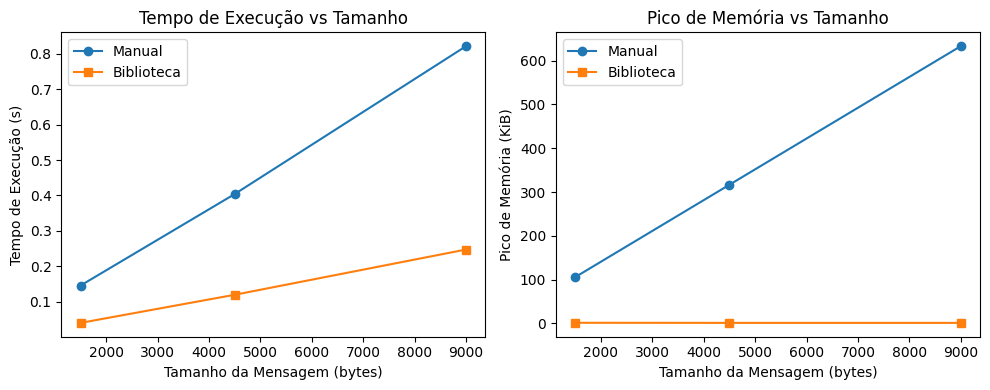

In [5]:
# Geração dos gráficos
import matplotlib.pyplot as plt

tamanhos = [r["tamanho"] for r in resultados]
tempos_manual = [r["tempo_manual"] for r in resultados]
tempos_lib = [r["tempo_lib"] for r in resultados]
mem_manual = [r["mem_pico_manual"] for r in resultados]
mem_lib = [r["mem_pico_lib"] for r in resultados]

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(tamanhos, tempos_manual, 'o-', label="Manual")
plt.plot(tamanhos, tempos_lib, 's-', label="Biblioteca")
plt.xlabel("Tamanho da Mensagem (bytes)")
plt.ylabel("Tempo de Execução (s)")
plt.title("Tempo de Execução vs Tamanho")
plt.legend()

plt.subplot(1,2,2)
plt.plot(tamanhos, mem_manual, 'o-', label="Manual")
plt.plot(tamanhos, mem_lib, 's-', label="Biblioteca")
plt.xlabel("Tamanho da Mensagem (bytes)")
plt.ylabel("Pico de Memória (KiB)")
plt.title("Pico de Memória vs Tamanho")
plt.legend()

plt.tight_layout()
plt.savefig("grafico_desempenho_crc.png")
plt.show()

## Parte 4 — Análise Investigativa da Detecção de Erros

Testando a detecção de erros inserindo rajadas de bits em posições aleatórias e comparando a detecção entre a implementação manual e a biblioteca:

In [6]:
import random

mensagem_base = "ananda"
mensagem_bits = (
    "01100001"  # a
    "01101110"  # n
    "01100001"  # a
    "01101110"  # n
    "01100100"  # d
    "01100001"  # a
)
gerador_bits = "11000000000000101"  # CRC-16/MODBUS

print("=== CONFIGURAÇÃO INICIAL ===")
print(f"MENSAGEM_BASE: {mensagem_bits}")
print(f"GERADOR: {gerador_bits}")

crc_calculado = calcular_crc_manual(mensagem_bits, gerador_bits)
print(f"CRC calculado: {crc_calculado}")

quadro_transmitido = mensagem_bits + crc_calculado
print(f"QUADRO_TRANSMITIDO: {quadro_transmitido}")

def inserir_erro_rajada(quadro_tx, n_bits):
    """
    Insere erro de rajada de n_bits em posição aleatória.
    Retorna: quadro_corrompido, posição, padrão_erro
    """
    pos = random.randint(0, len(quadro_tx) - n_bits)
    
    # Cria padrão de erro (todos zeros, exceto a rajada)
    padrao_erro = ['0'] * len(quadro_tx)
    for i in range(n_bits):
        padrao_erro[pos + i] = '1'
    padrao_erro = ''.join(padrao_erro)
    
    # Aplica XOR entre quadro_transmitido e padrão_erro
    quadro_corrompido = ''.join(
        '1' if quadro_tx[i] != padrao_erro[i] else '0' 
        for i in range(len(quadro_tx))
    )
    
    return quadro_corrompido, pos, padrao_erro

from crc import Calculator, Crc16
def verificar_crc_biblioteca(bits):
    """
    Calcula CRC usando biblioteca com melhor tratamento de erro
    """
    try:
        if len(bits) % 8 != 0:
            bits = bits.zfill(((len(bits) + 7) // 8) * 8)
        as_bytes = int(bits, 2).to_bytes(len(bits) // 8, byteorder='big')
        calculator = Calculator(Crc16.MODBUS)
        return calculator.checksum(as_bytes)
    except Exception as e:
        print(f"Erro na conversão: {e}")
        return -1

print("\n=== EXECUTANDO 10 TESTES ===")
resultados_teste = []

for teste in range(10):
    print(f"\n--- TESTE {teste + 1} ---")
    
    n_bits = random.randint(1, 8)
    quadro_corrompido, posicao, padrao_erro = inserir_erro_rajada(quadro_transmitido, n_bits)
    
    crc_manual_result = calcular_crc_manual(quadro_corrompido, gerador_bits)
    crc_lib_result = verificar_crc_biblioteca(quadro_corrompido)
    
    crc_esperado_zeros = '0' * 16
    detectado_manual = crc_manual_result != '0' * 16
    detectado_lib = crc_lib_result != 0
    
    resultado = {
        'teste': teste + 1,
        'n_bits': n_bits,
        'posicao': posicao,
        'padrao_erro': padrao_erro,
        'crc_manual': crc_manual_result,
        'crc_lib': crc_lib_result,
        'detectado_manual': detectado_manual,
        'detectado_lib': detectado_lib
    }
    resultados_teste.append(resultado)
    
    print(f"Rajada de {n_bits} bits na posição {posicao}")
    print(f"Padrão de erro: {padrao_erro}")
    print(f"CRC Manual: {crc_manual_result} {'✓ DETECTOU' if detectado_manual else '✗ NÃO DETECTOU'}")
    print(f"CRC Biblioteca: {crc_lib_result} {'✓ DETECTOU' if detectado_lib else '✗ NÃO DETECTOU'}")

print("\n=== RELATÓRIO FINAL ===")
print("Resumo dos 10 testes:")
for r in resultados_teste:
    status_manual = "✓" if r['detectado_manual'] else "✗"
    status_lib = "✓" if r['detectado_lib'] else "✗"
    print(f"Teste {r['teste']}: {r['n_bits']} bits na pos {r['posicao']} - Manual: {status_manual} | Lib: {status_lib}")

falhas_manual = sum(1 for r in resultados_teste if not r['detectado_manual'])
falhas_lib = sum(1 for r in resultados_teste if not r['detectado_lib'])

print(f"\n=== PONTOS CEGOS ENCONTRADOS ===")
print(f"- Implementação Manual: {falhas_manual} falhas")
print(f"- Biblioteca: {falhas_lib} falhas")

if falhas_manual > 0 or falhas_lib > 0:
    print("\nDETALHES DOS PONTOS CEGOS:")
    for r in resultados_teste:
        if not r['detectado_manual'] or not r['detectado_lib']:
            print(f"Teste {r['teste']}: Rajada de {r['n_bits']} bits na posição {r['posicao']}")
            if not r['detectado_manual']:
                print(f"  → Manual NÃO detectou (CRC: {r['crc_manual']})")
            if not r['detectado_lib']:
                print(f"  → Biblioteca NÃO detectou (CRC: {r['crc_lib']})")
                
print(f"\n=== ANÁLISE DE DESEMPENHO ===")
if falhas_manual == 0 and falhas_lib == 0:
    print("- Ambas as implementações detectaram todos os erros testados.")
    print("- O CRC-16 mostrou-se eficaz para os padrões de erro testados.")
elif falhas_manual > 0 or falhas_lib > 0:
    print("- Foram encontrados pontos cegos no CRC-16.")
    print("- Isso demonstra as limitações teóricas do algoritmo.")

print(f"\n=== LIMITAÇÕES IDENTIFICADAS ===")
if falhas_manual > 0 or falhas_lib > 0:
    print("- O CRC-16 não é infalível para todos os padrões de erro.")
    print("- Rajadas específicas podem passar despercebidas.")
    print("- Para aplicações críticas, CRC-32 seria mais adequado.")
else:
    print("- Nos testes realizados, o CRC-16 mostrou-se robusto.")
    print("- Isso não garante que seja infalível para todos os cenários.")
                
print(f"\n=== CONCLUSÕES ===")
print("- A implementação manual serve como uma boa ferramenta educacional.")
print("- A biblioteca oferece performance otimizada para uso em produção.")
print("- O CRC-16 é adequado para a maioria das aplicações, mas tem limitações.")
print("- Para comunicações críticas, algoritmos mais robustos são recomendados.")

=== CONFIGURAÇÃO INICIAL ===
MENSAGEM_BASE: 011000010110111001100001011011100110010001100001
GERADOR: 11000000000000101
CRC calculado: 1010000110111100
QUADRO_TRANSMITIDO: 0110000101101110011000010110111001100100011000011010000110111100

=== EXECUTANDO 10 TESTES ===

--- TESTE 1 ---
Rajada de 3 bits na posição 17
Padrão de erro: 0000000000000000011100000000000000000000000000000000000000000000
CRC Manual: 1000000001110100 ✓ DETECTOU
CRC Biblioteca: 28372 ✓ DETECTOU

--- TESTE 2 ---
Rajada de 1 bits na posição 19
Padrão de erro: 0000000000000000000100000000000000000000000000000000000000000000
CRC Manual: 1000000000010010 ✓ DETECTOU
CRC Biblioteca: 52957 ✓ DETECTOU

--- TESTE 3 ---
Rajada de 1 bits na posição 24
Padrão de erro: 0000000000000000000000001000000000000000000000000000000000000000
CRC Manual: 1011110000000011 ✓ DETECTOU
CRC Biblioteca: 32990 ✓ DETECTOU

--- TESTE 4 ---
Rajada de 2 bits na posição 28
Padrão de erro: 000000000000000000000000000011000000000000000000000000000000000